In [37]:
Ns=10 #only even numbers
N, PBC = 5, False
J, U,V = 1,40,0

In [38]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average, var, conj, math, var,append, save
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append([x for x in js_])
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

NoS1, NoS2, NoS = len(base1), len(base2), len(base)

print('Number of base states =',NoS)

Number of base states = 2002


In [39]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################

def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]
        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU
        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]
#print(H_2atom)
H = generateHamitlonian(base, J,U,V)
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS = sign(v[0,0])*v[:,0]

print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference GS... DONE in  328.65166664123535 [ms]


In [40]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def energy(c):
    return sum(real(conj(c)*H*c))

def getNis(c):
    out = zeros(Ns)
    for i in range(NoS):
        out += abs(c[i])**2*array(base[i])
    return out   

def getG2sX(c,x):
    G2s = zeros(Ns,dtype=complex)
    for i in range(NoS):
        fock = base[i]
        for xp in range(Ns):
            G2s[xp] += abs(c[i])**2*fock[x]*fock[xp]
            if x==xp:
                G2s[xp] -= abs(c[i])**2*fock[x]
    return G2s  

In [41]:
A1 = zeros([NoS,int((Ns+1)/2)],dtype=int)

for i in range(NoS):
    A1[i] = array(base[i][0:int((Ns+1)/2)])  + array(base[i][Ns:int((Ns-1)/2):-1])
        
#########################333####################################################################
combs = []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        
combsh = []
for n in range(Ns):
    for n2 in range(n, Ns):
        if n+n2 < Ns:
            combsh.append([n,n2])

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

A2 = zeros([NoS,len(combs)],dtype=int)
A2h = zeros([NoS,len(combsh)],dtype=int)


for i in range(NoS):
    A2[i] = P(base[i])
    A2h[i] = Ph(base[i])
    
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )

def variance1h( psi ):
    c = normalised(real(array(Norms1)*exp(A1.dot(log(psi,dtype=complex)))))
    return sum((c-GS)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    if method=='half':
        psi0h = GS_1atom[0:int((Ns+1)/2)]
        reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
        psi = append(reth.x, reth.x[::-1])
    if method=='whole':
        psi0 = GS_1atom
        ret = basinhopping(variance1, psi0, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=5)
        psi = ret.x
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

In [42]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################

def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def variance2( psi ):
    c = real(array(Norms1)*exp(A2.dot(log(psi,dtype=complex))))
    return 1-(c.dot(GS)/sqrt(c.dot(c)))**2

def variance2h( psi ):
    c = real(array(Norms1)*exp(A2h.dot(log(psi,dtype=complex))))
    return 1-(c.dot(GS)/sqrt(c.dot(c)))**2

def findPsi2():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = GS_2atom
    ret = minimize(variance2, psi0, method='Powell', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return ret.x

def findPsi2h():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2h, psi0, method='Powell', tol=1e-16, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

In [43]:
####################################################
## Compute best Ansatz functions ###################
####################################################
psiA1 = findPsi1()
#phiA21D = findPsi2()
phiA21D = findPsi2h()

phiA2 = reshapePhiTo2D(phiA21D)
phiJ = reshapePhiTo2D(GS_2atom)

Looking for Psi_A1... DONE in 1306.257963180542 [ms]
Looking for Psi_A2... DONE in 5398.61273765564 [ms]


(E_GS-E_free)/(|N E_free|) =  0.35156696531365433
(E_A1-E_free)/(|N E_free|) =  4.643096162143315
(E_A2-E_free)/(|N E_free|) =  0.3517215740830336
(E_J-E_free)/(|N E_free|) =  0.5227628197085904

|<ED|A1>|^2 =  0.015648321946516875
|<ED|A2>|^2 =  0.9999644590537532
|<ED|J>|^2 =  0.18515369789940955


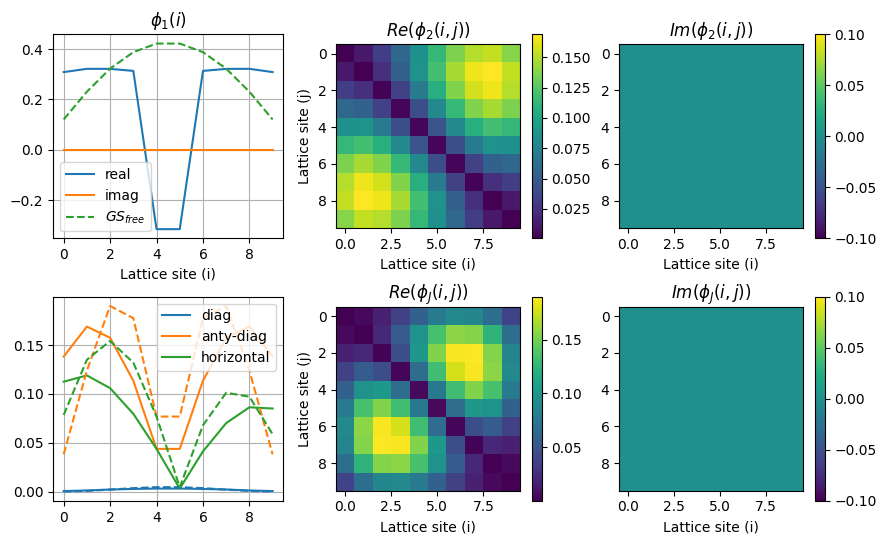

In [44]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np
psiA1 /= sqrt(sum(abs(psiA1)**2))

phiA21D /= sqrt(sum(sum(abs(phiA2)**2)))
phiA2 /= sqrt(sum(sum(abs(phiA2)**2)))

phiJ /= sqrt(sum(sum(abs(phiJ)**2)))

c1 = normalised( real(array(Norms1)*exp(A1.dot(log(psiA1[0:int(Ns/2)],dtype=complex)))) )
c2 = normalised( real(array(Norms1)*exp(A2.dot(log(phiA21D,dtype=complex)))) )
cJ = normalised( real(array(Norms1)*exp(A2.dot(log(GS_2atom,dtype=complex)))) )

EAnsatz1 = energy(c1)
EAnsatz2 = energy(c2)
EJ = energy(cJ)

print('(E_GS-E_free)/(|N E_free|) = ', (E_R-N*E_1atom)/(abs(N*E_1atom)) )
print('(E_A1-E_free)/(|N E_free|) = ',  (EAnsatz1-N*E_1atom)/(abs(N*E_1atom)) )
print('(E_A2-E_free)/(|N E_free|) = ',  (EAnsatz2-N*E_1atom)/(abs(N*E_1atom)) )
print('(E_J-E_free)/(|N E_free|) = ',  (EJ-N*E_1atom)/(abs(N*E_1atom)) )
print()
print('|<ED|A1>|^2 = ',(abs(c1.dot(GS))**2))
print('|<ED|A2>|^2 = ',(abs(c2.dot(GS))**2))
print('|<ED|J>|^2 = ',(abs(cJ.dot(GS))**2))

# print('|<ED|A1>|^2 = ',(1-0.5*variance1h(psiA1[0:int(Ns/2)]))**2)
# print('|<ED|A2>|^2 = ',(1-0.5*variance2(phiA21D))**2)
# print('|<ED|J>|^2 = ',(1-0.5*variance2(GS_2atom))**2)

fig, ax = plt.subplots(2,3,figsize=(9,5.5))
ax[0,0].plot(real(psiA1),label='real')
ax[0,0].plot(imag(psiA1),label='imag')
ax[0,0].plot(GS_1atom,'--',label = '$GS_{free}$')
cmap = ax[0,1].imshow(real(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[0,2].imshow(imag(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[1,1].imshow(real(phiJ))
cbar = plt.colorbar(cmap)
cmap = ax[1,2].imshow(imag(phiJ))
cbar = plt.colorbar(cmap)

# ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)])
# ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)])

ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].plot([real(phiJ)[i,i] for i in range(Ns)],'--',c='tab:blue')
ax[1,0].plot([real(phiJ)[i,Ns-1-i] for i in range(Ns)],'--',c='tab:orange')
ax[1,0].plot([real(phiJ)[int(Ns/2),i] for i in range(Ns)],'--',c='tab:green')


ax[0,0].grid()
ax[1,0].grid()
ax[1,0].legend()
ax[0,0].legend()
ax[0,0].set_xlabel('Lattice site (i)')
ax[0,1].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')
ax[0,2].set_xlabel('Lattice site (i)')
#ax[0,2].set_ylabel('Lattice site (j)')

ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re(\phi_2(i,j))$')
ax[0,2].set_title('$Im(\phi_2(i,j))$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')
#ax[1,2].set_ylabel('Lattice site (j)')

ax[1,1].set_title('$Re(\phi_J(i,j))$')
ax[1,2].set_title('$Im(\phi_J(i,j))$')
plt.tight_layout()
#plt.savefig("40_-1.97_N3_Ns30.func.png")
np.save(("Ns%i_N%i_J%f_U%f_V%f"%(Ns,N,J,U,V)),real(phiA2))
plt.savefig(("2_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))
#print(real(phiA2))
plt.show()

/home/maciek/.local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


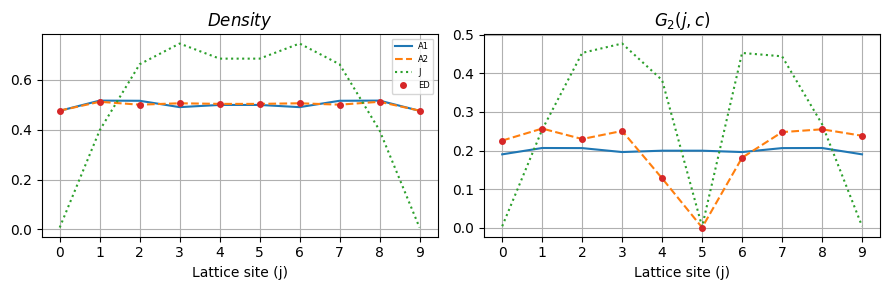

In [17]:
N1i, N2i, NJi, NiRef = getNis(c1), getNis(c2), getNis(cJ),getNis(GS)
nodeForG2 = int(Ns/2)
G12s,G22s, GJ2s, G2sRef = getG2sX(c1,int(Ns/2)),getG2sX(c2,int(Ns/2)), getG2sX(cJ,int(Ns/2)), getG2sX(GS,int(Ns/2))

fig, ax = plt.subplots(1,2,figsize=[9,3])
ax[0].plot(real(N1i),label="A1")
ax[0].plot(N2i,'--',label="A2")
ax[0].plot(NJi,linestyle='dotted',label="J")
#ax[0].plot(N2Ji,'--',label="J")
ax[0].plot(NiRef,'o',label="ED",markersize=4)
# ax[0].plot(N1i,label="$A1, (E1-E_{free})/N=$"+str(round((EAnsatz1-Efree[0])/N,4)))
# ax[0].plot(N2i,'--',label="$A2, (E2-E_{free})/N=$"+str(round((EAnsatz2-Efree[0])/N,4)))
# ax[0].plot(NiRef,'o',label="$ED, (ER-E_{free})/N=$"+str(round((E[0]-Efree[0])/N,4)))
ax[1].plot(G12s,label="A1")
ax[1].plot(G22s,'--',label="A2")
ax[1].plot(GJ2s,linestyle='dotted',label="J")
ax[1].plot(G2sRef,'o',label="ED",markersize=4)

ax[0].grid()
ax[1].grid()

ax[0].set_xlabel("Lattice site (j)")
ax[1].set_xlabel("Lattice site (j)")
ax[0].set_title("$Density$")
ax[1].set_title("$G_1(j,c)$")
ax[1].set_title("$G_2(j,c)$")
ax[0].legend(fontsize=6)

ax[0].set_xticks(range(0,Ns,1))
ax[1].set_xticks(range(0,Ns,1))
#ax[].set_xticks(range(0,Ns[N],1))
plt.tight_layout()
plt.savefig(("1_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))
#plt.savefig("tmpU"+str(U)+"V"+str(V)+".png")
plt.show()

In [381]:
from sympy.utilities.iterables import multiset_permutations
from operator import itemgetter
from numpy import outer, sort, concatenate
from numpy.linalg import svd
from math import factorial
from itertools import permutations
from time import sleep


u, λ, v =svd(real(phiA2**2), full_matrices=True)

λ*=-1
λ[0]*=-1

print(λ)

[ 0.12847612 -0.10411582 -0.02101266 -0.00141323 -0.00083252 -0.00058296
 -0.0001718  -0.00014717]


#### Density profile and G2 correlations


In [382]:
NCombs = []
for i in range(0,N):
    for j in range(i+1,N):
        NCombs.append([i,j])

def Λ(ls):
    out = 1
    for l in ls:
        out *= λ[l]
    return out

def f(l,num):
    out = []
    for i in range(len(NCombs)):
        if num in NCombs[i]:
            out.append(l[i])
    return array(out)

def B(fl):
    out = 1
    for k in range(0,N-1):
        out *= u[:,fl[k]]
    return out

def Γ(fl):
    return sum(B(fl))

factorialNCombs = factorial(len(NCombs))


def gen_N_G2(l):    
    outN = zeros(Ns,dtype=float)
    outG2 = zeros((Ns,Ns),dtype=float)
    for σl in multiset_permutations(l): 
        multip = 1    
        for i in range(2,N):
            multip *= Γ(f(σl,i))
            
        outN += B(f(σl,0))*Γ(f(σl,1)) * multip
        outG2 += outer( array(B(f(σl,0))) , array(B(f(σl,1))) ) * multip
    return factorialNCombs*Λ(l)*outN, factorialNCombs*Λ(l)*outG2


In [383]:
def keyToLs(key):
    out = [0]*len(NCombs)
    for i in range(0,len(NCombs)):
        out[len(NCombs)-1-i]=key%Ns
        key //= Ns
    return out

def lsToKey(ls):
    key = ls[0]
    for i in range(1,len(ls)):
        key*=Ns
        key+=ls[i]
    return key


ls = [0]*len(NCombs)
lss = {}

def numPerms(ls):
    out = 0
    for perm in multiset_permutations(ls):
        out+=1   
    return out

def numPermsB(ls):
    out = 1
    Na = 1
    slots = len(ls)
    lold = ls[0]
    for l in ls[1:]:
        if l != lold:
            out *= factorial(slots)/factorial(slots-Na)/factorial(Na)
            slots -= Na
            Na=1
            lold = l
        else:
            Na+=1
    return out

def appendL(i):
    if i == len(NCombs):
        key = lsToKey(ls)
        lss[key] = numPermsB(ls)*Λ(ls)
    else:
        for j in range(ls[i-1],Ns):
            ls[i]=j
            appendL(i+1)
            
print("Computing vaulues of combinations...",end='')
t0 = time.time()

for i0 in range(0,Ns):
    ls[0]=i0
    appendL(1)
print(" DONE in ",(time.time()-t0)*1000,"[ms]")        


lss = dict(sorted(lss.items(), key=lambda item: abs(item[1]),reverse=True))
keys = list(lss.keys())
coefs = list(lss.values())

Computing vaulues of combinations... DONE in  3.9899349212646484 [ms]


In [384]:
print(coefs[0:20])
print(coefs[30000:30020])
print(len(keys))  

[-4.786823473124923e-05, 4.430108294570733e-05, 2.909397143271758e-05, -2.8982312174099567e-05, 2.3486989989122308e-05, -2.1866536600523293e-05, 1.7881695767443653e-05, -9.516816592054225e-06, -9.430991035901068e-06, 7.110219122518803e-06, -5.849212417329229e-06, 4.4971193996921245e-06, -4.413106057220179e-06, -3.841369277185205e-06, -1.9492442275432543e-06, 1.80444259066581e-06, 1.5796489729199884e-06, 1.5424675207635335e-06, 1.273797564971726e-06, 1.202657401659055e-06]
[]
1716


Computing N and G2.. DONE in  454.01644706726074 [ms]


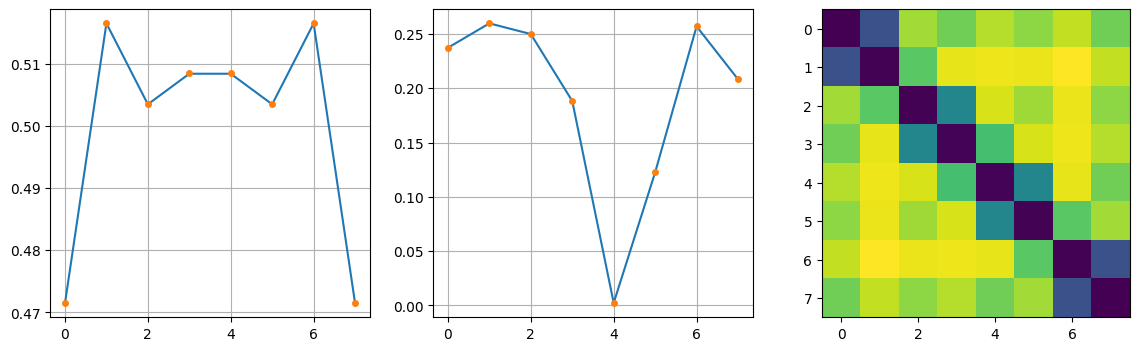

In [385]:
print("Computing N and G2..",end='')
t0 = time.time()


n,G2 = gen_N_G2(keyToLs(keys[0]))
for i in range(1,200):
    [nup,G2up] = gen_N_G2(keyToLs(keys[i]))
    n+=nup
    G2+=G2up
    
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(real(n)*NiRef[0]/real(n[0]),'-')
ax[0].plot(NiRef,'o',label="ED",markersize=4)
ax[1].plot([G2[i,int(Ns/2)]*G2sRef[0]/G2[0,int(Ns/2)] for i in range(Ns)],'-',label="math")
ax[1].plot(G2sRef,'o',label="ED",markersize=4)
ax[2].imshow(G2)

ax[0].grid()
ax[1].grid()
plt.show()

##Effective Hamitlonian


In [386]:
NoSeff = len(base2)
H = lil_matrix((NoSeff,NoSeff),dtype=float)
for i in range(NoSeff):
    sL = base2[i]
    for j in range(0,Ns-1):
        if sL[j]>0:
            coef = -J*sqrt(sL[j])*sqrt(sL[j+1]+1)
            sR = [x for x in sL]
            sR[j]-=1
            sR[j+1]+=1
            ip = base2.index(sR)
            H[i,ip]+=coef
            H[ip,i]+=coef

        
        
#phiA21D = GS_2atom
phiA21D /= sqrt(phiA21D.dot(phiA21D))
def diff(Veff):
    for i in range(NoSeff):
        H[i,i] = Veff[i]
    vec = H.dot(phiA21D)
    vec /= sqrt(vec.dot(vec))
    return sum( abs(vec-phiA21D) )

In [387]:
print("Looking for Veff...",end='')
minimizer_kwargs = {"method": "Powell","tol":1e-6,"bounds":[(-100,100)]*NoSeff}
t0 = time.time()

V0 = [0]*NoSeff
ret = basinhopping(diff, V0, minimizer_kwargs=minimizer_kwargs, niter=200,niter_success=6)
V = ret.x
print(V)

V = [v-30 for v in V]
print(V)
print(" DONE in",(time.time()-t0)*1000,"[ms]")

Looking for Veff...[79.86277238 62.94091321 62.97409396 63.05733079 63.0547479  63.07239215
 63.0314309  62.34057361 89.41304072 63.75882699 63.76305197 63.75552268
 63.76819733 63.72549149 63.03143088 87.01761175 63.82246902 63.78230827
 63.80468323 63.76819731 63.07239213 87.80450449 63.81532504 63.78230823
 63.75552265 63.05474784 87.80450448 63.82246905 63.76305191 63.0573305
 87.01761173 63.75882708 62.97409391 89.41304061 62.94091339 79.86277253]
[49.86277237783919, 32.940913208948345, 32.97409396103087, 33.05733079027727, 33.054747900793835, 33.07239215185002, 33.03143089577385, 32.34057360504625, 59.41304071837584, 33.75882699275788, 33.76305197278263, 33.75552268382782, 33.76819733265437, 33.72549148849963, 33.03143087886947, 57.017611753150234, 33.82246901883108, 33.78230827174274, 33.80468322561338, 33.76819731254753, 33.07239213180074, 57.80450449168718, 33.81532503661542, 33.782308228981215, 33.75552265030911, 33.05474783809197, 57.80450447814549, 33.82246905109658, 33.763

In [388]:
tmp1 = H.dot(phiA21D)
tmp1 /= sqrt(tmp1.dot(tmp1))
#print(phiA21D.dot(phiA21D))
print(sum(abs(tmp1-phiA21D)))
#print(phiA21D)

print(phiA21D)

6.64575106968171e-09
[0.00240715 0.03366159 0.08579151 0.14669866 0.20717721 0.24987497
 0.26537479 0.23545565 0.00487234 0.06737633 0.14285763 0.21839306
 0.27356379 0.29619692 0.26537479 0.00840935 0.09276465 0.17770457
 0.24273174 0.27356379 0.24987497 0.00998226 0.10288404 0.17770457
 0.21839306 0.20717721 0.00998226 0.09276465 0.14285763 0.14669866
 0.00840935 0.06737633 0.08579151 0.00487234 0.03366159 0.00240715]


In [390]:
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS_eff = sign(v[0,0])*v[:,0]

print(sum(abs(GS_eff-phiA21D)))
print(GS_eff)

1.4523827663584163e-07
[0.00240715 0.03366159 0.08579151 0.14669868 0.20717722 0.24987496
 0.26537478 0.23545564 0.00487234 0.06737633 0.14285763 0.21839306
 0.27356378 0.29619691 0.26537479 0.00840935 0.09276466 0.17770457
 0.24273174 0.27356379 0.24987497 0.00998226 0.10288404 0.17770457
 0.21839307 0.20717723 0.00998226 0.09276465 0.14285764 0.14669868
 0.00840935 0.06737634 0.08579152 0.00487234 0.0336616  0.00240715]


In [360]:
#V40 = V
#V39p9 = V
#V0 = V
#V10=V
#V20=V
#V30 = V

In [361]:
dV = array(V40)-array(V39p9)

print(array(V40)-array(V39p9))

[0.15828128 0.09278949 0.09296911 0.09288012 0.09289877 0.09289294
 0.1811646  0.0928714  0.09289329 0.09290461 0.09289879 0.17345689
 0.09282663 0.09289326 0.09288019 0.17345657 0.09287109 0.09296953
 0.18116441 0.09278952 0.1582812 ]


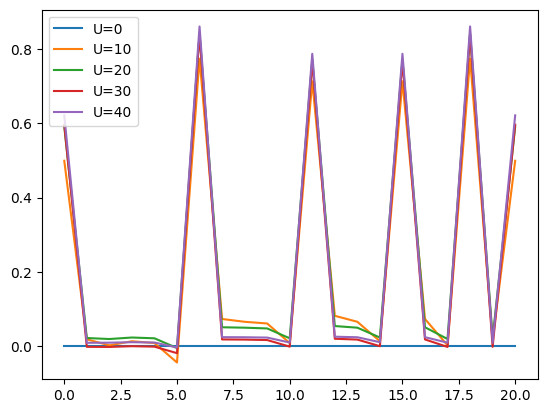

In [371]:
plt.plot(V0,label="U=0")
plt.plot([v/10-0.4 for v in V10],label="U=10")
plt.plot([v/20-0.1 for v in V20],label="U=20")
plt.plot([v/30-0.05 for v in V30],label="U=30")
plt.plot([v/40-0.02 for v in V40],label="U=40")

plt.legend()
plt.show()

0 -0.00113263066323437
1 0.001726491696637097
2 0.004348669988117886
3 -0.0009247123117606003
4 0.0010428205178271675
5 -0.0008462178208749069
6 0.0007603046916727472
7 -0.00046692542594337246
8 0.000469843476037402
9 0.0005584604707993847
10 0.00020237354225223153
11 0.0006601822748919483
12 -0.0003289381820983405
13 0.001442644784997428
14 1.8015775120557386e-05
15 0.0002233777627837277
16 -0.00014953207581814207
17 0.0014643725208854739
18 0.0004698443327755388
19 0.0036667185683279444
20 -0.005963321803266503
21 -0.0018738799280575214
22 -0.0009908382169546252
23 -5.030609270784221e-05
24 -0.0015958748281934903
25 -0.00014953164744907366
26 -0.00046692471199492506
27 0.0036366042228185083
28 0.004697509911555316
29 -0.0011085141986311637
30 0.00020027967424582864
31 -5.030894850163163e-05
32 0.0002233791906806224
33 0.0007603056912005735
34 0.0015629773688465747
35 -0.004823686163446064
36 -0.0011085153409486795
37 -0.0009908355039505252
38 1.8013204906146906e-05
39 -0.000846216964